In [1]:
import pandas as pd
import re
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, Dropout, GlobalMaxPooling1D
from keras.layers import Flatten
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from gensim import corpora
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk import FreqDist
from nltk.tokenize import word_tokenize


In [2]:
df= pd.read_csv("cleaned_songs_data.csv", encoding = 'latin-1')
df2 = df.drop(columns =['Album_Path', 'labels','weird_labels'])
df2.head()



,ID,Tracks,Album_ID,Album,lyrics
0,6206232,the 1 (the long pond studio sessions),1027134,folklore: the long pond studio sessions (Recor...,"[Verse 1]\nI'm doing good, I'm on some new shi..."
1,6206211,cardigan (the long pond studio sessions),1027134,folklore: the long pond studio sessions (Recor...,"[Verse 1]\nVintage tee, brand new phone\nHigh ..."
2,6206233,the last great american dynasty (the long pond...,1027134,folklore: the long pond studio sessions (Recor...,[Verse 1]\nRebekah rode up on the afternoon tr...
3,6206234,exile (the long pond studio sessions),1027134,folklore: the long pond studio sessions (Recor...,[Verse 1: Justin Vernon]\nI can see you standi...
4,6206235,my tears ricochet (the long pond studio sessions),1027134,folklore: the long pond studio sessions (Recor...,"[Verse 1]\nWe gather here, we line up, weepin'..."


In [ ]:
df2['lyrics'] = df2['lyrics'].replace(to_replace='<.*?>', value='', regex=True)


palavras = ['Intro', 'Verse 1', 'Chorus', 'Verse 2', 'Chorus', 'Bridge', 'Verse 3', 'Chorus', 'Verse 4', 'Break', 'Verse 5', 'Outro', 'Post-Chorus', 'Pre-Chorus','Oh Oh']
df2['lyrics'] = df2['lyrics'].replace(to_replace=palavras, value='', regex=True)

def remove_special_chars(x):
    return re.sub("[^a-zA-Z0-9 ]", " ", x)


df2['lyrics'] = df2['lyrics'].apply(remove_special_chars)
df2['lyrics'] = df2['lyrics'].str.lower()

df2.head()

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
df2['lyrics'] = df2['lyrics'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

palavras = ['verse', 'pre-chorus', 'chorus']
df2['lyrics'] = df2['lyrics'].str.replace('|'.join(palavras), '')


df2.head()


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,ID,Tracks,Album_ID,Album,lyrics
0,6206232,the 1 (the long pond studio sessions),1027134,folklore: the long pond studio sessions (Recor...,good new shit saying yes instead thought saw b...
1,6206211,cardigan (the long pond studio sessions),1027134,folklore: the long pond studio sessions (Recor...,vintage tee brand new phone high heels cobbles...
2,6206233,the last great american dynasty (the long pond...,1027134,folklore: the long pond studio sessions (Recor...,rebekah rode afternoon train sunny saltbox hou...
3,6206234,exile (the long pond studio sessions),1027134,folklore: the long pond studio sessions (Recor...,justin vernon see standing honey arms around b...
4,6206235,my tears ricochet (the long pond studio sessions),1027134,folklore: the long pond studio sessions (Recor...,gather line weepin sunlit room fire made ashes...


In [ ]:
df2_a = pd.unique(df2['Album_ID'].values.ravel())
df2_albuns = pd.DataFrame(df2_a, columns=['Album'])

In [ ]:
album_genre_mapping = {
1027134: 'Alternativa/Indie',
1013719: 'Pop',
1013715: 'Pop',
1013718: 'Country/Pop',
1008313: 'Pop',
969188: 'Pop',
962334: 'Pop',
959034: 'Pop',
949856: 'Pop',
945000: 'Pop',
921019: 'Alternativa/Indie',
916591: 'Country/Pop',
873527: 'Alternativa/Indie',
862870: 'Country/Pop',
862869: 'Country/Pop',
862783: 'Country/Pop',
861675: 'Country/Pop',
859646: 'Country/Pop',
758022: 'Country/Pop',
779383: 'Alternativa/Indie',
776228: 'Country',
775761: 'Country',
773617: 'Country',
771313: 'Country',
734107: 'Country',
731261: 'Alternativa/Indie',
12682: 'Country',
350177: 'Country',
597883: 'Pop',
22453: 'Country/Pop',
110728: 'Pop',
350247: 'Pop',
520929: 'Pop',
659925: 'Alternativa/Indie',
710140: 'Alternativa/Indie',
10982: 'Country/Pop',
14637: 'Country/Pop',
710147: 'Alternativa/Indie',
726425: 'Alternativa/Indie',
728549: 'Alternativa/Indie',
725953: 'Alternativa/Indie'

}

df2['genre'] = df2['Album_ID'].map(album_genre_mapping)
taylor = df2
taylor

,ID,Tracks,Album_ID,Album,lyrics,genre
0,6206232,the 1 (the long pond studio sessions),1027134,folklore: the long pond studio sessions (Recor...,good new shit saying yes instead thought saw b...,Alternativa/Indie
1,6206211,cardigan (the long pond studio sessions),1027134,folklore: the long pond studio sessions (Recor...,vintage tee brand new phone high heels cobbles...,Alternativa/Indie
2,6206233,the last great american dynasty (the long pond...,1027134,folklore: the long pond studio sessions (Recor...,rebekah rode afternoon train sunny saltbox hou...,Alternativa/Indie
3,6206234,exile (the long pond studio sessions),1027134,folklore: the long pond studio sessions (Recor...,justin vernon see standing honey arms around b...,Alternativa/Indie
4,6206235,my tears ricochet (the long pond studio sessions),1027134,folklore: the long pond studio sessions (Recor...,gather line weepin sunlit room fire made ashes...,Alternativa/Indie
...,...,...,...,...,...,...
455,6260166,happiness,725953,evermore: the dropped your hand while dancing ...,honey trees see right years given shit dividin...,Alternativa/Indie
456,6260178,its time to go,725953,evermore: the dropped your hand while dancing ...,dinner cold chatter gets old ask tab moment in...,Alternativa/Indie
457,6260164,tolerate it,725953,evermore: the dropped your hand while dancing ...,sit watch reading head low wake watch breathin...,Alternativa/Indie
458,6260168,coney island,725953,evermore: the dropped your hand while dancing ...,taylor swift soul two looking right relate any...,Alternativa/Indie


In [ ]:
#cnn
max_words = 1000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(taylor['lyrics'])
sequences = tokenizer.texts_to_sequences(taylor['lyrics'])
padded_sequences = pad_sequences(sequences, padding='post', maxlen=100)

label_encoder = LabelEncoder()
taylor['encoded_genre'] = label_encoder.fit_transform(taylor['genre'])
labels_categorical = to_categorical(taylor['encoded_genre'])


train_data, test_data, train_labels, test_labels = train_test_split(padded_sequences, labels_categorical, test_size=0.5, random_state=42)

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=padded_sequences.shape[1]))

model.add(LSTM(20))
model.add(Dense(labels_categorical.shape[1],activation='sigmoid'))

custom_optimizer = Adam(lr=0.05)

model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_data, train_labels, epochs=200, validation_split=0.5)

loss, accuracy = model.evaluate(test_data, test_labels)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

Epoch 1/200
4/4 [==============================] - 3s 263ms/step - loss: 0.6928 - accuracy: 0.2348 - val_loss: 0.6881 - val_accuracy: 0.3217
Epoch 2/200
4/4 [==============================] - 0s 71ms/step - loss: 0.6827 - accuracy: 0.4783 - val_loss: 0.6813 - val_accuracy: 0.3565
Epoch 3/200
4/4 [==============================] - 0s 71ms/step - loss: 0.6725 - accuracy: 0.5739 - val_loss: 0.6732 - val_accuracy: 0.3913
Epoch 4/200
4/4 [==============================] - 0s 63ms/step - loss: 0.6600 - accuracy: 0.5913 - val_loss: 0.6630 - val_accuracy: 0.3826
Epoch 5/200
4/4 [==============================] - 0s 63ms/step - loss: 0.6447 - accuracy: 0.5739 - val_loss: 0.6490 - val_accuracy: 0.3652
Epoch 6/200
4/4 [==============================] - 0s 74ms/step - loss: 0.6242 - accuracy: 0.5391 - val_loss: 0.6287 - val_accuracy: 0.3478
Epoch 7/200
4/4 [==============================] - 0s 64ms/step - loss: 0.5957 - accuracy: 0.5217 - val_loss: 0.6008 - val_accuracy: 0.3478
Epoch 8/200
4/4 [==

8/8 [==============================] - 1s 10ms/step


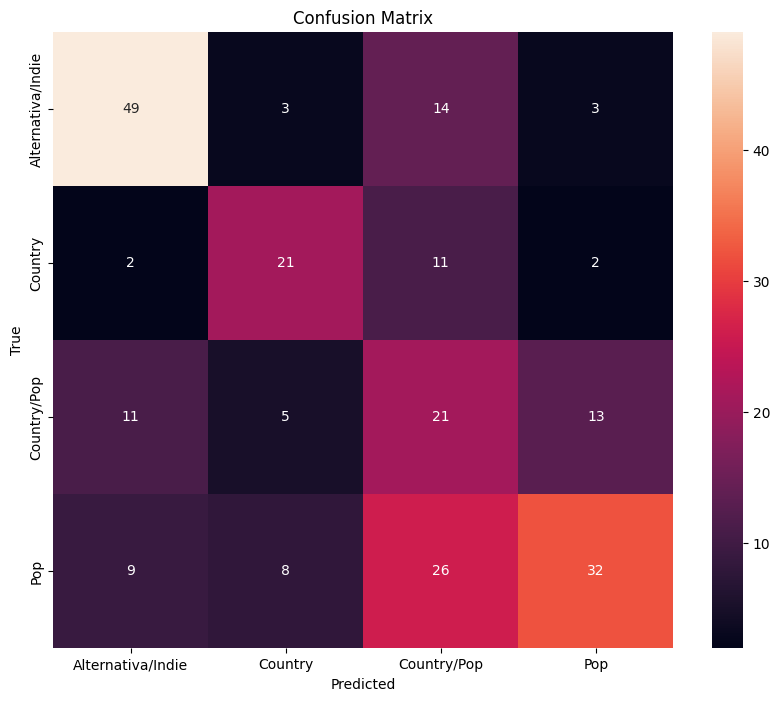

In [ ]:
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)
predicted_genre = label_encoder.inverse_transform(predicted_labels)

true_labels = label_encoder.inverse_transform(np.argmax(test_labels, axis=1))
test_data_df = pd.DataFrame(test_data)


results_df = pd.DataFrame({
    'Tracks': taylor['Tracks'].iloc[test_data_df.index].values,
    'Lyric': taylor['lyrics'].iloc[test_data_df.index].values,
    'True Genre': true_labels,
    'Predicted Genre': predicted_genre
})


conf_matrix = confusion_matrix(true_labels, predicted_genre)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
results_df

,Tracks,Lyric,True Genre,Predicted Genre
0,the 1 (the long pond studio sessions),good new shit saying yes instead thought saw b...,Country/Pop,Alternativa/Indie
1,cardigan (the long pond studio sessions),vintage tee brand new phone high heels cobbles...,Country/Pop,Country
2,the last great american dynasty (the long pond...,rebekah rode afternoon train sunny saltbox hou...,Country,Country
3,exile (the long pond studio sessions),justin vernon see standing honey arms around b...,Alternativa/Indie,Alternativa/Indie
4,my tears ricochet (the long pond studio sessions),gather line weepin sunlit room fire made ashes...,Country/Pop,Country/Pop
...,...,...,...,...
225,Come In With The Rain (Taylors Version),could go back every laugh wanna go anymore kno...,Country/Pop,Pop
226,Superstar (Taylors Version),wrong help feel like nothing right babe misty ...,Pop,Country/Pop
227,The Other Side of the Door (Taylors Version),heat fight walked away ignorin words sayin try...,Country/Pop,Country/Pop
228,Today Was a Fairytale (Taylors Version),today fairytale prince used damsel distress to...,Alternativa/Indie,Alternativa/Indie


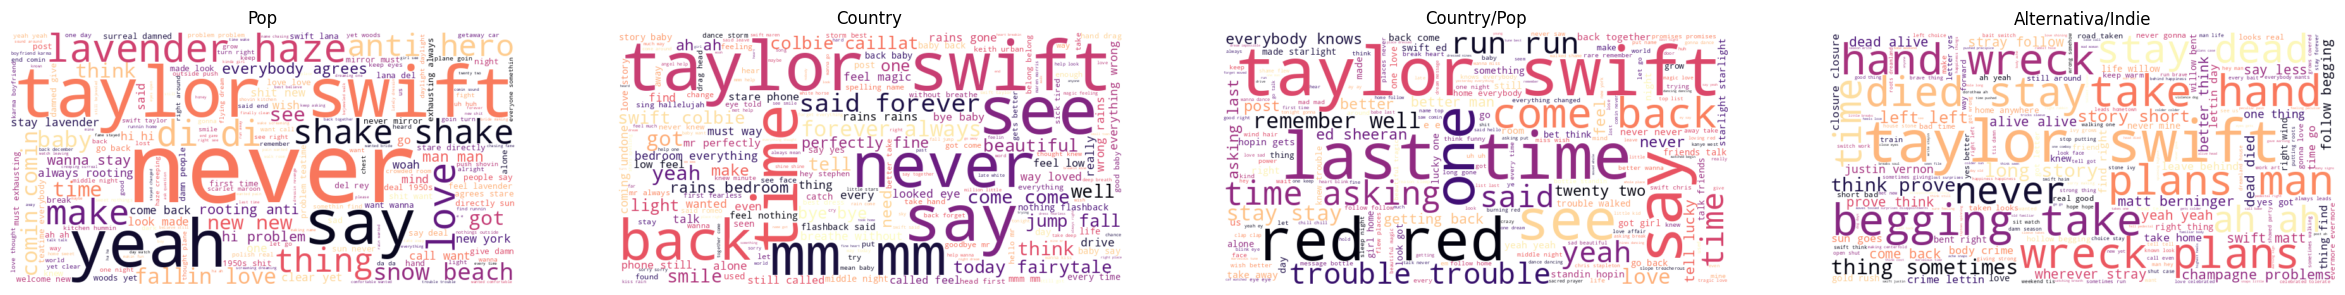

In [ ]:
lyrics_by_genre = {
    'Pop': ' '.join(taylor[taylor['genre'] == 'Pop']['lyrics']),
    'Country': ' '.join(taylor[taylor['genre'] == 'Country']['lyrics']),
    'Country/Pop': ' '.join(taylor[taylor['genre'] == 'Country/Pop']['lyrics']),
    'Alternativa/Indie': ' '.join(taylor[taylor['genre'] == 'Alternativa/Indie']['lyrics'])

}

custom_stopwords = ["ooh", "oh", "cause", "know", "might", "la", "pre"]
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap="magma", stopwords=set(STOPWORDS.union(custom_stopwords)))


plt.figure(figsize=(30, 15))
for i, (genre, text) in enumerate(lyrics_by_genre.items(), start=1):
    plt.subplot(1, len(lyrics_by_genre), i)
    wordcloud.generate_from_text(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(genre)
    plt.axis('off')

plt.show()


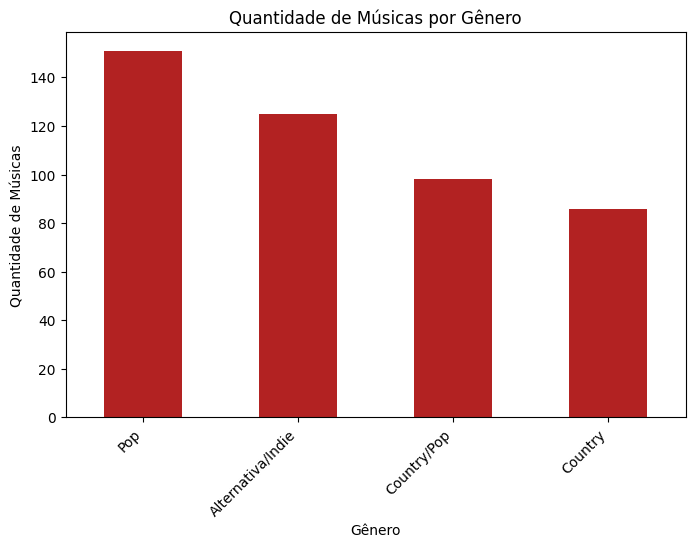

In [ ]:
contagem_por_genero = taylor['genre'].value_counts()

plt.figure(figsize=(8, 5))
contagem_por_genero.plot(kind='bar',color='firebrick')
plt.title('Quantidade de Músicas por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Quantidade de Músicas')
plt.xticks(rotation=45, ha='right')
plt.show()

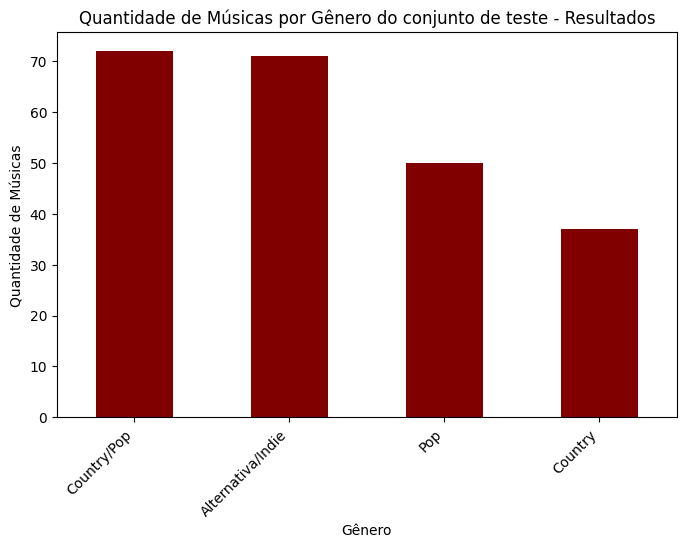

In [ ]:
contagem_por_genero = results_df['Predicted Genre'].value_counts()

plt.figure(figsize=(8, 5))
contagem_por_genero.plot(kind='bar', color='maroon')
plt.title('Quantidade de Músicas por Gênero do conjunto de teste - Resultados')
plt.xlabel('Gênero')
plt.ylabel('Quantidade de Músicas')
plt.xticks(rotation=45, ha='right')
plt.show()

                                                lyrics              genre  \
0    good new shit saying yes instead thought saw b...  Alternativa/Indie   
1    vintage tee brand new phone high heels cobbles...  Alternativa/Indie   
2    rebekah rode afternoon train sunny saltbox hou...  Alternativa/Indie   
3    justin vernon see standing honey arms around b...  Alternativa/Indie   
4    gather line weepin sunlit room fire made ashes...  Alternativa/Indie   
..                                                 ...                ...   
455  honey trees see right years given shit dividin...  Alternativa/Indie   
456  dinner cold chatter gets old ask tab moment in...  Alternativa/Indie   
457  sit watch reading head low wake watch breathin...  Alternativa/Indie   
458  taylor swift soul two looking right relate any...  Alternativa/Indie   
459  one smoking gun eclipsed sun broken twisted kn...  Alternativa/Indie   

     lexical_diversity  
0             0.620000  
1             0.629412  


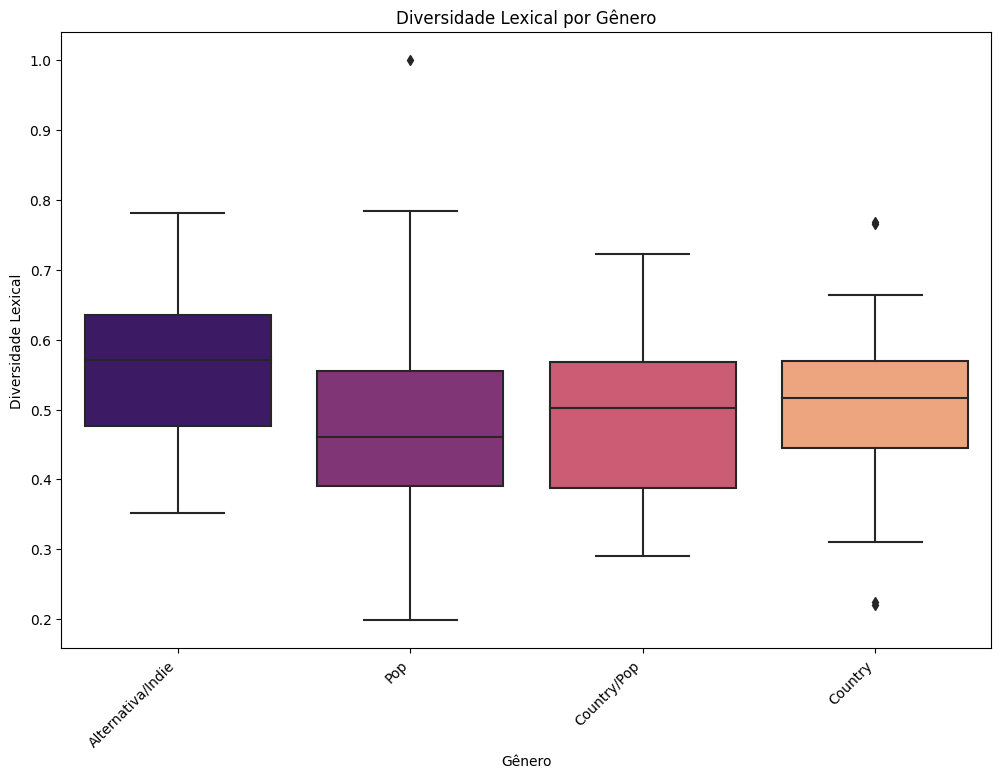

In [ ]:


taylor['tokenized_lyrics'] = taylor['lyrics'].apply(word_tokenize)

taylor['lexical_diversity'] = taylor['tokenized_lyrics'].apply(lambda x: len(set(x)) / len(x) if len(x) > 0 else 0)
print(taylor[['lyrics', 'genre', 'lexical_diversity']])

plt.figure(figsize=(12, 8))
sns.boxplot(x='genre', y='lexical_diversity', data=taylor, palette='magma',)
plt.title('Diversidade Lexical por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Diversidade Lexical')
plt.xticks(rotation=45, ha='right')
plt.show()

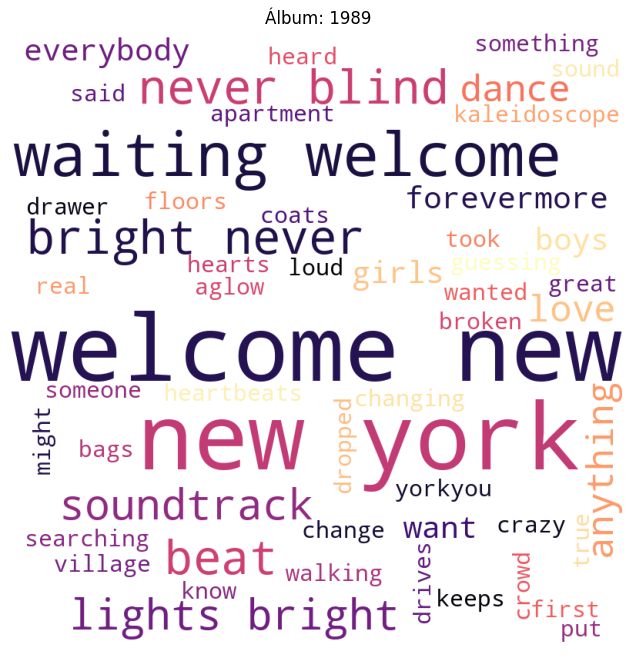

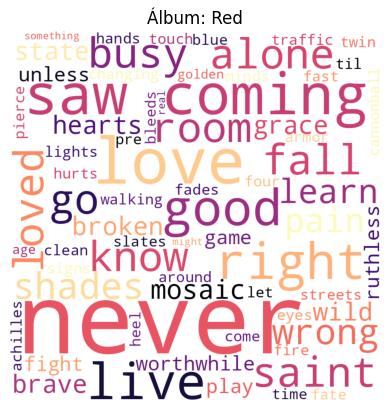

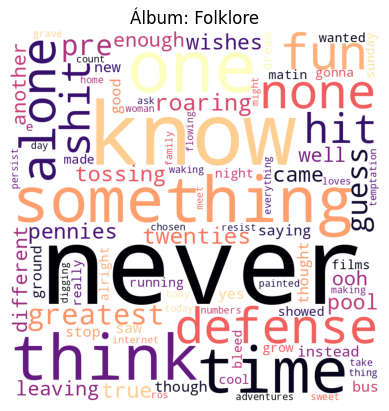

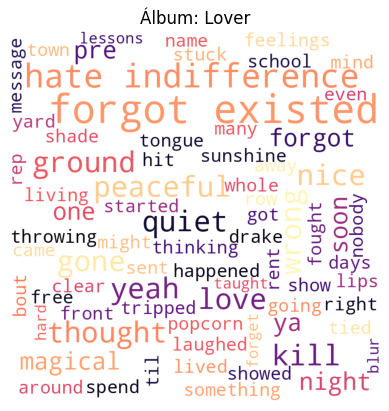

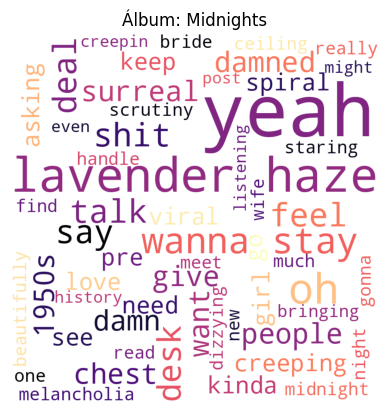

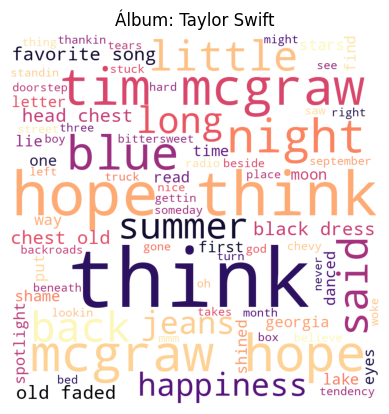

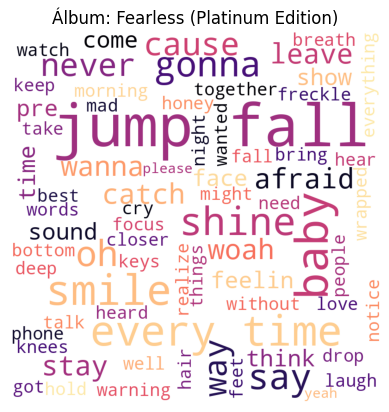

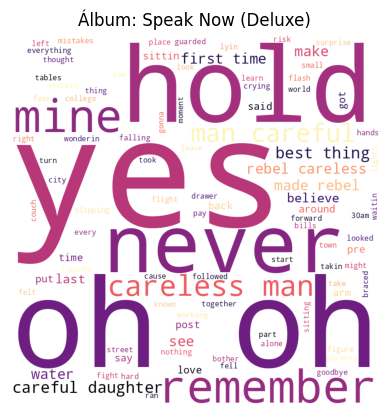

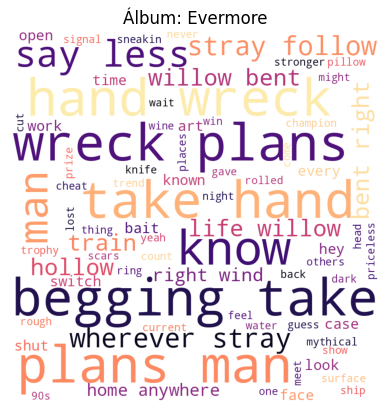

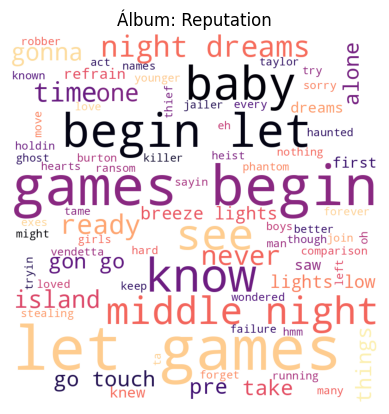

In [ ]:
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
dtm = vectorizer.fit_transform(taylor['lyrics'])

id2word = corpora.Dictionary([vectorizer.get_feature_names_out()])
corpus = [id2word.doc2bow(word.split()) for word in taylor['lyrics']]
album_lyrics = taylor.groupby('Album')['lyrics'].apply(' '.join).reset_index()

albuns_selecionados = ['1989', 'Red', 'Folklore', 'Lover', 'Midnights',  'Taylor Swift', 'Fearless (Platinum Edition)', 'Speak Now (Deluxe)', 'Evermore', 'Reputation']

taylor_selecionado = taylor[taylor['Album'].isin(albuns_selecionados)]

num_topics = 5
lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42)


plt.figure(figsize=(8, 8))
for album in albuns_selecionados:
    album_text = taylor_selecionado[taylor_selecionado['Album'] == album]['lyrics'].values[0]
    plt.imshow(WordCloud(width=800, height=800, background_color='white',colormap="magma").generate(album_text))
    plt.axis('off')
    plt.title(f'Álbum: {album}')
    plt.show()

In [ ]:
from textblob import TextBlob

def analyze_sentiment(text):
    analysis = TextBlob(text)
    # -1 (negativa) a 1 (positiva)
    return analysis.sentiment.polarity

taylor['sentiment_score'] = taylor['lyrics'].apply(analyze_sentiment)
print(taylor[['lyrics', 'sentiment_score']])

                                                lyrics  sentiment_score
0    good new shit saying yes instead thought saw b...         0.274242
1    vintage tee brand new phone high heels cobbles...         0.113588
2    rebekah rode afternoon train sunny saltbox hou...         0.290379
3    justin vernon see standing honey arms around b...         0.159023
4    gather line weepin sunlit room fire made ashes...        -0.046591
..                                                 ...              ...
455  honey trees see right years given shit dividin...         0.296007
456  dinner cold chatter gets old ask tab moment in...         0.195669
457  sit watch reading head low wake watch breathin...         0.231250
458  taylor swift soul two looking right relate any...         0.082468
459  one smoking gun eclipsed sun broken twisted kn...         0.028193

[460 rows x 2 columns]


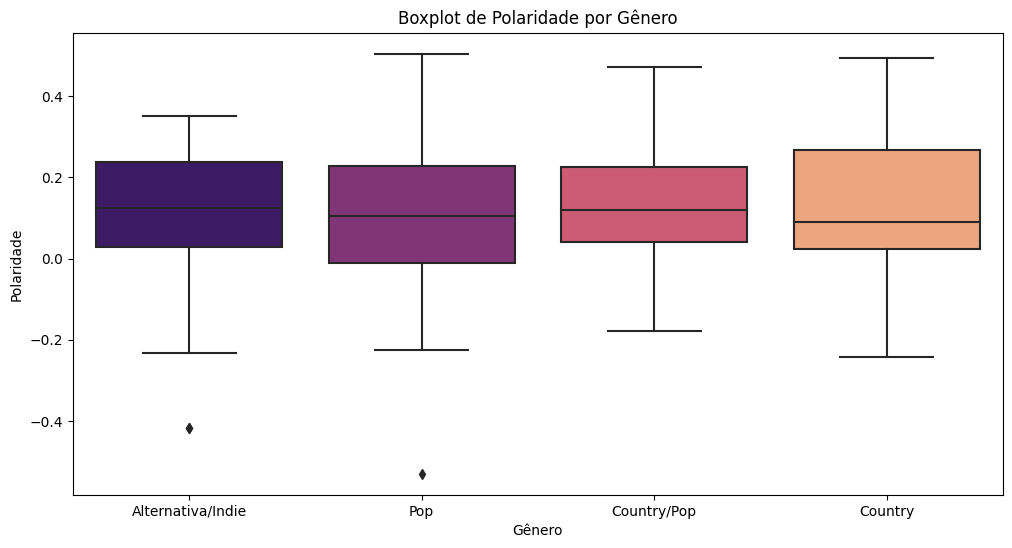

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='genre', y='sentiment_score', data=taylor, palette ='magma')
plt.title('Boxplot de Polaridade por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Polaridade')
plt.show()

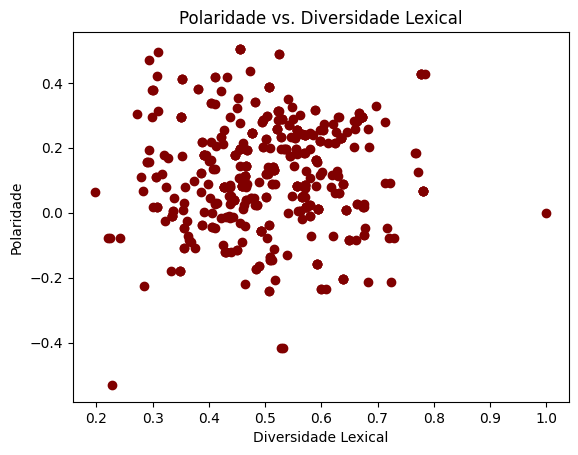

In [ ]:
plt.scatter(taylor['lexical_diversity'], taylor['sentiment_score'], color='maroon')
plt.title('Polaridade vs. Diversidade Lexical')
plt.xlabel('Diversidade Lexical')
plt.ylabel('Polaridade')
plt.show()